In [1]:
#%pip install feos
#%pip install gpy
#%pip install emukit

# hot fix for numpy>1.16.4
import numpy
numpy.testing.Tester = None

import numpy as np
import pandas as pd
import glob, os
from feos.si import * # SI numbers and constants
from feos.pcsaft import *
from feos.eos import *
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize,curve_fit

from multi_fidelity_viscosity.entropy_scaling import *
from multi_fidelity_viscosity.multi_entropy_utils import *

import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

np.random.seed(20)

In [5]:
saft_paras = "pcsaft/20191105_pure_parameters_feos.json"



name = "butanol"
sim = False 
experimental_noise = 0.01

#name = "propane"
#sim = False 
#experimental_noise = 0.01

viscosity_reference = get_CE_viscosity_reference


simdata: database


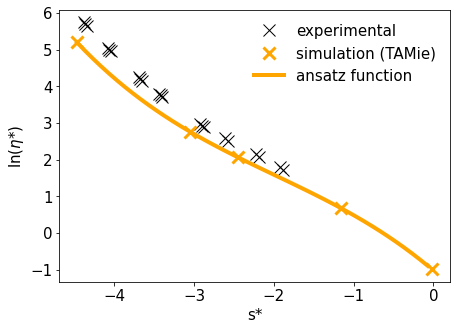

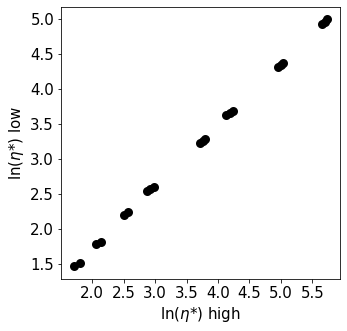

In [6]:
units = {}
units["temperatures"] = KELVIN
units["densities"]    = KILOGRAM/METER**3  
units["viscosities"]  = MILLI*PASCAL*SECOND 
units["viscosity_reference"]  = MILLI*PASCAL*SECOND 
units["pressures"]    = KILO*PASCAL
units["residual_entropies"]    = 1.
units["ln_viscosity_star"]    = 1.
units["state"]    = False

try:
    os.mkdir(name)
except:
    None

path = name + "/all_data/"    
try:
    os.mkdir(path)
except:
    None


# get PC-SAFT parameters
parameters = PcSaftParameters.from_json(
    [name.split("_")[0]], 
    saft_paras, 
    search_option="name"
)

M = parameters.pure_records[0].molarweight *(GRAM/MOL)
m = parameters.pure_records[0].model_record.m

"""
Here experimental data is loaded and processed.
Result: representation of experimental data in entropy space
"""

path_vis = name.split("_")[0]+"/experimental/"+name.split("_")[0]+".json" 
path_vis = name+"/experimental/"+name+".json" 

with open(path_vis) as json_file:
    experimental = json.load(json_file)

experimental = apply_units(experimental, units)    
experimental = viscosity_prho_entropy_space( experimental, parameters, viscosity_reference )

liquid_only = True
#liquid_only = False
if liquid_only:
    experimental = split_dataset(experimental, 
                                     #np.squeeze(np.where( experimental["residual_entropies"] < -1 )),
                                     np.squeeze(np.where( experimental["state"] == "L" )),
                                     units
                                    )
else:
    experimental = split_dataset(experimental, 
                                     #np.squeeze(np.where( experimental["residual_entropies"] < -1 )),
                                     np.squeeze(np.where( experimental["residual_entropies"] < 1 )),
                                     units
                                    )

"""
Here simulation data is loaded and processed.
Result: representation of simulation results in entropy space
"""

print("simdata: database")
simdata = pd.read_excel( "simulations/simulation_results.xlsx" )
simdata = simdata[ simdata["molecule"] == name.split("_")[0] ]

# collect simulation data and assign units
simulation  = {}
simulation["temperatures"]  = np.array(simdata.temperature)*KELVIN
simulation["densities"   ]  = np.array(simdata.density)*KILOGRAM/METER**3
simulation["viscosities" ]  = np.array(simdata.viscosity)*MILLI*PASCAL*SECOND
simulation["pressures"   ]     = np.empty(len(simulation["temperatures"]))

simulation = viscosity_prho_entropy_space( simulation, parameters, viscosity_reference ) 

# fit polynomial ansatz function to simulation
simansatz = ansatz_test( simulation["residual_entropies"], simulation["ln_viscosity_star"], viscosity_correlation )
simansatz.train()

pex = np.squeeze(np.where(experimental["residual_entropies"] >= np.min(simulation["residual_entropies"]) ))
experimental = split_dataset( experimental, pex, units )

x_simrep = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_simrep,_ = simansatz.predict(x_simrep)
xdata   = [ experimental["residual_entropies"], simulation["residual_entropies"], x_simrep ]
ydata   = [ experimental["ln_viscosity_star"], simulation["ln_viscosity_star"],  y_simrep]
yfill   = [ "", "", "" ]
markers = [ "x", "x", "-" ] 
colors  = [ "black", "orange", "orange" ] 
labels  = [ "experimental", "simulation (TAMie)", "ansatz function" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_simulation_fit" )

dummy, _ = simansatz.predict(experimental["residual_entropies"])
x_hi   = [ experimental["ln_viscosity_star"] ]
x_lo   = [ dummy ]
markers = [ "." ] 
colors  = [ "black","green" ] 
labels  = [ "" ] 
linear_plot( x_hi, x_lo, markers, colors, labels, path+"subspace_exsim_angle" ) 

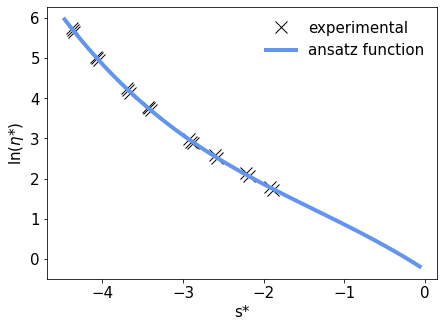

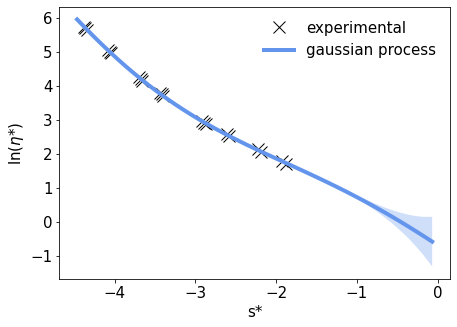

In [7]:
# fit  polynomial ansatz function to experimental 
exansatz = ansatz_test( experimental["residual_entropies"], experimental["ln_viscosity_star"], viscosity_correlation )
exansatz.train()

x_an = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_an,_ = exansatz.predict(x_an)
xdata   = [ experimental["residual_entropies"], x_an ]
ydata   = [ experimental["ln_viscosity_star"], y_an ]
yfill   = [ "", "" ]
markers = [ "x", "-" ] 
colors  = [ "black", "cornflowerblue" ] 
labels  = [ "experimental", "ansatz function" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_ansatz_fit"  )

# fit gaussian process to experimental 
exgp = gp_test( experimental["residual_entropies"], experimental["ln_viscosity_star"] )
exgp.train()

x_gp = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_gp, fillyy = exgp.predict(x_gp)
x_an = np.arange( np.min(simulation["residual_entropies"]),np.max(simulation["residual_entropies"]), .1 )
y_an,_ = exansatz.predict(x_an)
xdata   = [ experimental["residual_entropies"], x_gp ]
ydata   = [ experimental["ln_viscosity_star"], y_gp ]
yfill   = [ "", fillyy ]
markers = [ "x", "-" ] 
colors  = [ "black", "cornflowerblue" ] 
labels  = [ "experimental", "gaussian process" ] 
entropy_plot( xdata, ydata, yfill, markers, colors, labels, path+"subspace_gp_fit" )

In [8]:
normer = experimental["viscosity_reference"] /units["viscosity_reference"]
yref    = experimental["viscosities"] /units["viscosities"]

#pmf_error     = get_superspace_error( experimental["residual_entropies"],yref,normer,mf_poly)
#mf_error     = get_superspace_error( experimental["residual_entropies"],yref,normer,exmf)
ansatz_error = get_superspace_error( experimental["residual_entropies"],yref,normer,exansatz)
gp_error     = get_superspace_error( experimental["residual_entropies"],yref,normer,exgp)
sim_error     = get_superspace_error( experimental["residual_entropies"],yref,normer,simansatz)

#print("mf_error ", mf_error)
#print("pmf_error", pmf_error)
print("an_error ", ansatz_error)
print("gp_error ", gp_error)
print("sim_error ", sim_error)

an_error  1.3971212124397643
gp_error  1.3933516448365855
sim_error  37.430199620133976


In [9]:
ansatz_logerror = get_superspace_log_error( experimental["residual_entropies"],yref,normer,exansatz)
gp_logerror     = get_superspace_log_error( experimental["residual_entropies"],yref,normer,exgp)
sim_logerror    = get_superspace_log_error( experimental["residual_entropies"],yref,normer,simansatz)

#print("mf_error ", mf_error)
#print("pmf_error", pmf_error)
print("ansatz_logerror ", ansatz_logerror)
print("gp_logerror ", gp_logerror)
print("sim_logerror ", sim_logerror)

ansatz_logerror  1.395258964288306
gp_logerror  1.3917063923533364
sim_logerror  48.222353900217115


In [6]:
excel_file = "poly_results.xlsx"
timestamp = datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

if "__________________" in name:
    print("special case ? Dont save")
else:    
    df = {}
    df["molecule"] = name #.split("/")[-1]
    df["sim_error"] = round(sim_error,2)  
    df["an_error"] = round(ansatz_error,2)
    df["gp_error"] = round(gp_error,2)
    #df["mf_error"] = round(mf_error,2)
    #df["pmf_error"] = round(pmf_error,2)    
    df["datapoints"] = len(experimental["residual_entropies"])
    #df["A"] = mf_poly.popt[0]
    #df["B"] = mf_poly.popt[1]
    #df["C"] = mf_poly.popt[2]
    #df["D"] = mf_poly.popt[3]
    df["timestamp"] = timestamp
    
    df = pd.DataFrame({k: [v] for k, v in df.items()})#.set_index('run')
    try:
        print("try")
        dfx = pd.read_excel( excel_file )
        dummy = pd.concat([dfx, df ], sort=False,  ignore_index=True )
        df0 = dummy.drop(index=[ x for x in dummy.keys() if "Unnamed" in x ])
    except:
        print("except")
        df0 = df
    df0 = df0.drop_duplicates(subset='molecule', keep='last')    
    df0.to_excel( excel_file, index = False)   
    
name    

try


'butanol'